# Bias-Variance Decomposition

This library can also be used to compute the classic bias-variance decomposition for all implemented losses.

### Using BVDExperiment

We show how we can measure changing the maximum number of leaf nodes in a `DecisionTreeRegressor` affects the bias and variance of the model.

In [1]:
from decompose import SquaredLoss, BVDExperiment, data_utils
from sklearn.tree import DecisionTreeRegressor

train_X, train_y, test_X, test_y = data_utils.load_standard_dataset("california", frac_training=0.8)
experiment = BVDExperiment(DecisionTreeRegressor(),
                           loss="squared",
                           parameter_name="max_leaf_nodes",
                           parameter_values=range(5, 18, 1),
                           )

results = experiment.run_experiment(train_X, train_y, test_X, test_y, n_trials=200, n_test_splits=1)

100%|██████████| 13/13 [01:48<00:00,  8.37s/it]


<AxesSubplot:xlabel='max_leaf_nodes'>

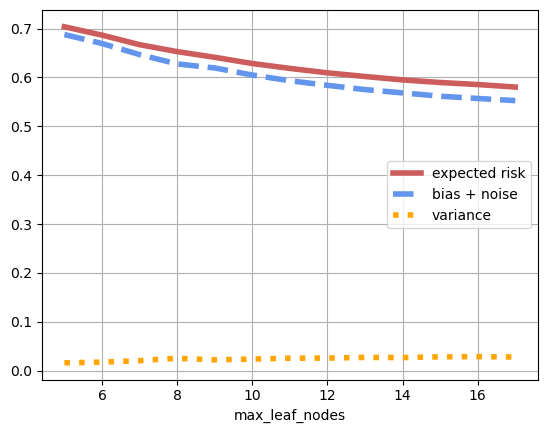

In [2]:
from decompose import plotting_utils

# We can use the plot_bv function in plotting_utils to easily plot the outputs.
plotting_utils.plot_bv(results)

### Using Decomposition Directly

We show how the bias-variance decomposition can be calculated by using a Decomposition class directly. In this case, CrossEntropy.

In [3]:
from sklearn.neural_network import MLPClassifier
from decompose import CrossEntropy
import numpy as np

n_trials = 5

train_X, train_y, test_X, test_y = data_utils.load_standard_dataset("digits", frac_training=0.8)

# Create the numpy array storing model outputs
# Note that the size of the array is (n_trials, ensemble_size, n_test_points, n_classes)
# A single model is treated as an ensemble of size 1
model_outputs = np.zeros((n_trials, 1, test_y.shape[0], 10))

# Collect model outputs for each trial
for idx in range(n_trials):
    model = MLPClassifier()
    model.fit(train_X, train_y)
    this_model_output = model.predict_proba(test_X)
    this_model_output = (1 - 1e-6) * this_model_output + 1e-7 * np.ones_like(this_model_output)

    model_outputs[idx, 0, :, :]  = this_model_output

decomposition = CrossEntropy(model_outputs, test_y)

print(f"expected risk: {decomposition.expected_ensemble_loss.mean()}")
print(f"bias: {decomposition.ensemble_bias.mean()}")
print(f"variance: {decomposition.ensemble_variance.mean()}")


expected risk: 0.11120379938821653
bias: 0.08553776864336396
variance: 0.02566603074485266


# Ambiguity Decomposition

Similarly to the bias-variance decomposition, the library can be used for computing the ambiguity decomposition.

## Using BVDExperiment
We now show how the ambiguity decomposition for a  single ensemble can be derived using BVDExperiment.

In [4]:
from decompose import SquaredLoss, BVDExperiment, data_utils
from sklearn.ensemble import RandomForestRegressor

ensemble_sizes = np.arange(1, 11)
train_X, train_y, test_X, test_y = data_utils.load_standard_dataset("california", frac_training=0.8)
experiment = BVDExperiment(RandomForestRegressor(warm_start=True),
                           loss="squared",
                           parameter_name="n_estimators",
                           parameter_values=ensemble_sizes,
                           n_samples=1.,
                           bootstrap=False
                           )

results = experiment.run_experiment(train_X,
                                    train_y,
                                    test_X,
                                    test_y,
                                    n_trials=1,
                                    n_test_splits=1)

100%|██████████| 10/10 [00:01<00:00,  7.99it/s]


Loss : 0.33873953682296115
Average Loss : 0.5670898495797811
Ambiguity : 0.22835031275682


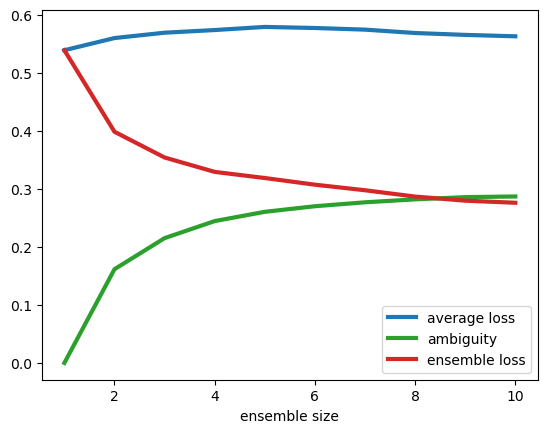

In [5]:
import matplotlib.pyplot as plt

plt.plot(ensemble_sizes, results.average_bias, label="average loss", lw=3)
plt.plot(ensemble_sizes, results.diversity, label="ambiguity", lw=3, c="tab:green")
plt.plot(ensemble_sizes, results.ensemble_risk, label="ensemble loss", lw=3, c="tab:red")
plt.xlabel("ensemble size")
plt.legend()

print(f"Loss : {results.ensemble_risk.mean()}")
print(f"Average Loss : {results.average_bias.mean()}")
print(f"Ambiguity : {results.diversity.mean()}")

### Using Decomposition Directly

In the following example, we train a `RandomForestRegressor`, then extract the ouputs of the ensemble to perform an ambiguity decomposition.

In [6]:
from decompose import SquaredLoss, BVDExperiment, data_utils
from sklearn.ensemble import RandomForestRegressor
import numpy as np

n_estimators = 10

ensemble_sizes = np.arange(1, 11)
train_X, train_y, test_X, test_y = data_utils.load_standard_dataset("california", frac_training=0.8)

model = RandomForestRegressor(n_estimators=n_estimators).fit(train_X, train_y)
# Ambiguity is diversity of a single trial, so we set the dimension for n_trials to be of size 1
outputs = np.zeros((1, n_estimators, test_y.shape[0]))

for est_idx, estimator in enumerate(model.estimators_):
    outputs[0, est_idx, :] = estimator.predict(test_X)

decomposition = SquaredLoss(outputs, test_y)

print(f"Ensemble Loss: {decomposition.expected_ensemble_loss.mean()}")
print(f"Average Loss: {decomposition.average_bias.mean()}")
print(f"Ambiguity: {decomposition.diversity.mean()}")

Ensemble Loss: 0.25768068045019715
Average Loss: 0.5349878411875969
Ambiguity: 0.27730716073739975
